In [6]:
import os
import pickle
import repackage
repackage.up()
import os.path as osp
from nuscenes.nuscenes import NuScenes
from tqdm import tqdm
import pandas as pd
import numpy as np
from datasets.nuscenes import NuScenesMultipleRadarMultiSweeps
from utils.labelling import get_sps_labels
from utils.transforms import *

In [3]:
sps_df = pd.read_json('../nuscenes_scenes_df.json')
sps_df.head()

,scene_name,first_frame_datetime,days_since_first_recording,hours_since_first_recording,month,split,closest_scenes,closest_scenes_data
122,scene-0162,1526922463034,0,0.005553,May,trainval,[scene-0665],{'scene-0665': {'scene_token': '45275e709d4a4b...
126,scene-0166,1526922575054,0,0.036670,May,trainval,[scene-0440],{'scene-0440': {'scene_token': '64e1ad8a976542...
127,scene-0167,1526922613046,0,0.047223,May,trainval,"[scene-0079, scene-0653, scene-0442]",{'scene-0079': {'scene_token': '1e4818b3b2354b...
128,scene-0168,1526922652038,0,0.058055,May,trainval,[scene-0444],{'scene-0444': {'scene_token': 'a2e3c0a763c04e...
129,scene-0170,1526922817015,0,0.103882,May,trainval,[scene-0331],{'scene-0331': {'scene_token': '9d1307e95c524c...


In [3]:
ref_frame = None
num_sweeps = 5
ref_sensor = None
apply_dpr = True
filter_points = False
dpr_thresh = 0.75

data_dir = "/shared/data/nuScenes/"
sps_maps_dir = "../output_sw5-dpr0.75-r1_filter_radius/labelled_maps/"
sensors = ["RADAR_FRONT", "RADAR_FRONT_LEFT", "RADAR_FRONT_RIGHT", "RADAR_BACK_LEFT", "RADAR_BACK_RIGHT"]
versions = {'trainval': 'v1.0-trainval', 'test': 'v1.0-test'}
nuscenes_exp = {
    vname : NuScenes(dataroot=data_dir, version=version, verbose=False)\
    for vname,version in versions.items()
}

In [4]:
def extract_data(dataset):
    num_frames = len(dataset)
    global_poses = dataset.global_poses
    ego_timestamps = dataset.timestamps
    all_data = []

    for i in range(num_frames):
        frame_dict = {}
        (pointclouds, sps_scores), calibs, sensors, timestamps = dataset[i]

        for sensor, calib, ts, pcl, scores in zip(sensors, calibs, timestamps, pointclouds, sps_scores):
            frame_dict[sensor] = {
                'calib' : calib,
                'timestamp': ts,
                'pointcloud': pcl,
                'stability_scores': scores
            }
        frame_dict['ego_pose'] = global_poses[i]
        frame_dict['ego_timestamp'] = ego_timestamps[i]
        all_data.append(frame_dict)
    return all_data

In [5]:
row = sps_df.iloc[0]
ref_scene_name = row['scene_name']
ref_split = row['split']
closest_scenes = row['closest_scenes_data']
seq = int(ref_scene_name.split("-")[-1])


dataset_sequence = NuScenesMultipleRadarMultiSweeps(
    data_dir=data_dir,
    nusc=nuscenes_exp[ref_split],
    sequence=seq,
    sensors=sensors,
    nsweeps=num_sweeps,
    ref_frame=ref_frame,
    ref_sensor=ref_sensor,
    sps_thresh=0.0,
    return_sps_scores=True,
    sps_labels_dir=sps_maps_dir,
    apply_dpr=apply_dpr,
    filter_points=filter_points,
    ransac_threshold=dpr_thresh

)

data = extract_data(dataset_sequence)

In [6]:
print(seq)

162


In [7]:
data[0]['ego_timestamp']

[1526915263.338853,
 1526915263.403805,
 1526915263.358866,
 1526915263.409038,
 1526915263.349147]

In [8]:
data[0]['ego_pose']

array([[ 9.99519025e-01, -3.10116046e-02,  0.00000000e+00,
         2.25583758e+03],
       [ 3.10116046e-02,  9.99519025e-01,  0.00000000e+00,
         8.57782891e+02],
       [ 0.00000000e+00,  0.00000000e+00,  1.00000000e+00,
         0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         1.00000000e+00]])

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap


def plot_pointclouds(sensor_data, ego_pose):
    """
    Plots the pointclouds from all sensors in the global frame with color coding based on stability scores.
    """
    all_points = []
    all_scores = []

    for sensor, data in sensor_data.items():
        if sensor == 'ego_pose':
            continue
        calib_matrix = data['calib']
        pointcloud = data['pointcloud']
        stability_scores = data['stability_scores']
        
        # Transform points from sensor to ego vehicle frame
        ego_frame_points = transform_doppler_points(calib_matrix, pointcloud)
        
        # Transform points from ego vehicle frame to global frame
        global_frame_points = transform_doppler_points(ego_pose, ego_frame_points)
        
        # Append points and their color based on individual stability scores
        all_points.append(global_frame_points)
        all_scores.append(stability_scores)
    
    all_points = np.vstack(all_points)
    all_scores = np.concatenate(all_scores)

    # Create scatter plot
    fig = plt.figure(figsize=(16, 16))
    ax = fig.add_subplot(111)
    sc = ax.scatter(all_points[:, 0], all_points[:, 1], c=all_scores, cmap='RdYlGn', s=0.5)
    
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    plt.colorbar(sc)
    plt.title('Pointclouds from All Sensors in Global Frame')
    plt.show()

WARNING - 2024-08-06 10:41:09,654 - legend - No handles with labels found to put in legend.


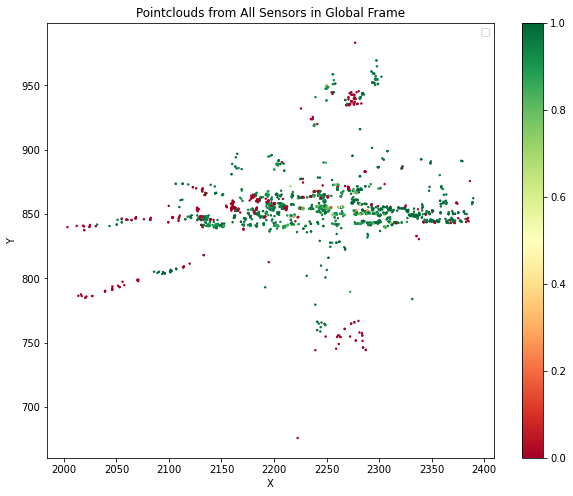

In [23]:
idx = 1
plot_pointclouds(data[idx], data[idx]['ego_pose'])

In [16]:
def concatenate_sensor_data(sensor_data_array):
    """
    Concatenates data from an array of sensor_data dictionaries, maintaining the keys and structure.
    """
    concatenated_data = {}
    
    # Initialize concatenated_data with empty structures
    for sensor in sensor_data_array[0]:
        if sensor == 'ego_pose':
            concatenated_data[sensor] = sensor_data_array[0][sensor]
        else:
            concatenated_data[sensor] = {
                'calib': sensor_data_array[0][sensor]['calib'],
                'timestamp': [],
                'pointcloud': [],
                'stability_scores': []
            }
    
    # Concatenate data from all sensor_data dictionaries
    for data in sensor_data_array:
        for sensor, values in data.items():
            if sensor == 'ego_pose':
                continue
            concatenated_data[sensor]['timestamp'].append(values['timestamp'])
            concatenated_data[sensor]['pointcloud'].append(values['pointcloud'])
            concatenated_data[sensor]['stability_scores'].append(values['stability_scores'])
    
    # Convert lists to numpy arrays where applicable
    for sensor in concatenated_data:
        if sensor == 'ego_pose':
            continue
        concatenated_data[sensor]['timestamp'] = np.array(concatenated_data[sensor]['timestamp'])
        concatenated_data[sensor]['pointcloud'] = np.vstack(concatenated_data[sensor]['pointcloud'])
        concatenated_data[sensor]['stability_scores'] = np.hstack(concatenated_data[sensor]['stability_scores'])
    
    return concatenated_data

In [25]:
all_data = concatenate_sensor_data(data)

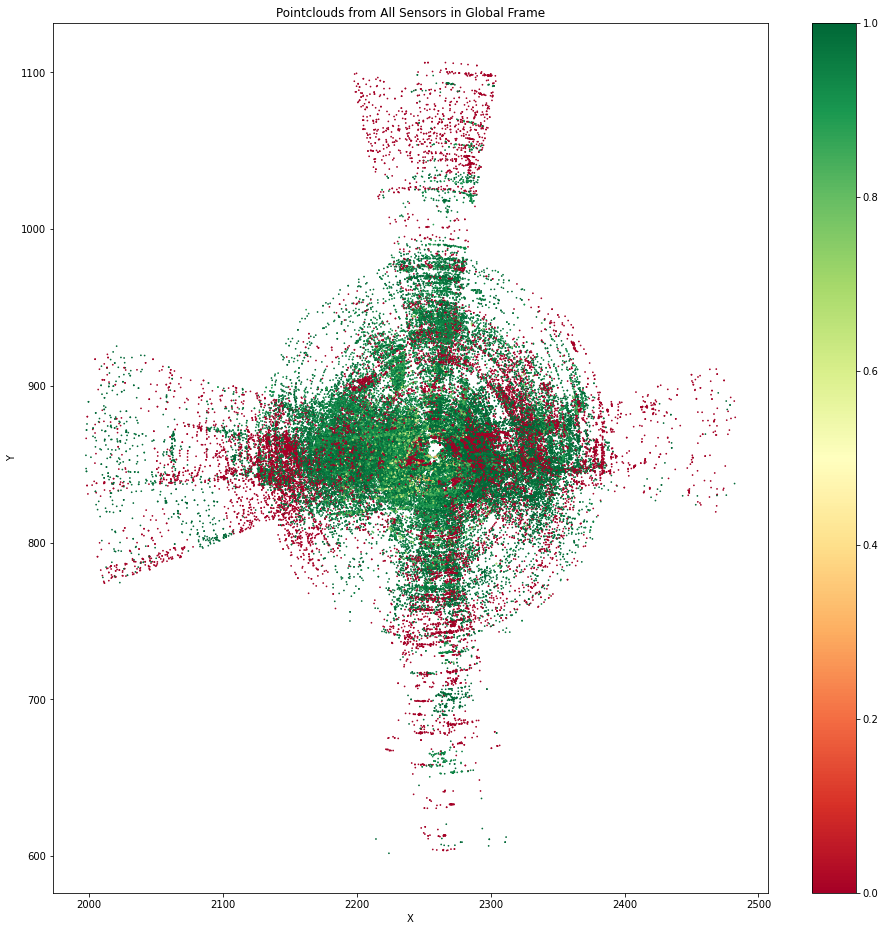

In [32]:
plot_pointclouds(all_data, all_data['ego_pose'])

In [22]:
import os
def save_sensor_data(data, sequence_name, base_dir):
    """
    Save the concatenated sensor data to disk in the specified structure.
    
    Parameters:
    - data: The list of sensor data dictionaries.
    - sequence_name: The name of the sequence for which data is being saved.
    - base_dir: The base directory where the data will be saved.
    """
    # Create directories
    sequence_dir = os.path.join(base_dir, "sequence", sequence_name)
    scans_dir = os.path.join(sequence_dir, "scans")
    poses_dir = os.path.join(sequence_dir, "poses")
    map_transform_dir = os.path.join(sequence_dir, "map_transform")

    os.makedirs(scans_dir, exist_ok=True)
    os.makedirs(poses_dir, exist_ok=True)
    os.makedirs(map_transform_dir, exist_ok=True)

    # Process each element in the data list
    for idx, sensor_data in enumerate(data):
        combined_pointclouds = []
        for sensor in sensor_data:
            if sensor == 'ego_pose' or sensor == 'ego_timestamp':
                continue

            calib_matrix = sensor_data[sensor]['calib']
            pointclouds = sensor_data[sensor]['pointcloud']
            
            transformed_points = transform_doppler_points(calib_matrix, pointclouds)
            combined_pointclouds.append(transformed_points)

        combined_pointcloud = np.vstack(combined_pointclouds)
        
        # Save combined pointcloud and ego pose
        ego_timestamp = str(np.mean(np.array(sensor_data['ego_timestamp'])))
        scan_file = os.path.join(scans_dir, f"{ego_timestamp}.npy")
        pose_file = os.path.join(poses_dir, f"{ego_timestamp}.txt")

        np.save(scan_file, combined_pointcloud)
        np.savetxt(pose_file, sensor_data['ego_pose'], delimiter=',')

        # Save a dummy map_transform file if needed
        map_transform_file = os.path.join(map_transform_dir, "map_transform.txt")
        if not os.path.exists(map_transform_file):
            dummy_transform = np.eye(4)
            np.savetxt(map_transform_file, dummy_transform, delimiter=',')

In [26]:
base_dir = "/home/umair/workspace/radar_sps_datasets/nuscenes"
src_maps_dir = "/home/umair/workspace/radar_auto_labeler/output_sw5-dpr0.5-r2_combined_maps/labelled_maps/"
dst_maps_dir = os.path.join(base_dir, "maps")
import shutil
shutil.copytree(src_maps_dir, dst_maps_dir)

'/home/umair/workspace/radar_sps_datasets/nuscenes/maps'

In [27]:
for i,row in tqdm(sps_df.iterrows(), total=len(sps_df)):
    ref_scene_name = row['scene_name']
    ref_split = row['split']
    closest_scenes = row['closest_scenes_data']
    seq = int(ref_scene_name.split("-")[-1])


    dataset_sequence = NuScenesMultipleRadarMultiSweeps(
        data_dir=data_dir,
        nusc=nuscenes_exp[ref_split],
        sequence=seq,
        sensors=sensors,
        nsweeps=num_sweeps,
        ref_frame=ref_frame,
        ref_sensor=ref_sensor,
        sps_thresh=0.0,
        return_sps_scores=True,
        sps_labels_dir=sps_maps_dir,
        apply_dpr=apply_dpr,
        filter_points=filter_points,
        ransac_threshold=dpr_thresh

    )

    data = extract_data(dataset_sequence)
    save_sensor_data(data, ref_scene_name, base_dir)

  0%|          | 0/102 [00:00<?, ?it/s]

 59%|█████▉    | 60/102 [1:14:32<52:10, 74.54s/it]  


KeyboardInterrupt: 

In [9]:

def combine_maps(sps_maps_dir):
    """
    Combines all .asc maps from the given directory into a single map and writes it to disk.
    
    Parameters:
    - sps_maps_dir: The directory containing the .asc map files.
    """
    combined_data = []

    # Iterate through all .asc files in the directory
    for file_name in os.listdir(sps_maps_dir):
        if file_name.endswith(".asc"):
            file_path = os.path.join(sps_maps_dir, file_name)
            # Read the .asc file
            data = np.loadtxt(file_path, skiprows=1)
            combined_data.append(data)
    
    # Combine all the data into a single array
    combined_data = np.vstack(combined_data)
    
    # Determine the output file path one level up from sps_maps_dir
    parent_dir = os.path.abspath(os.path.join(sps_maps_dir, os.pardir))
    output_file = os.path.join(parent_dir, "combined_map.asc")
    
    # Write the combined data to a new .asc file
    np.savetxt(output_file, combined_data, fmt="%.6f")
    print(f"Combined map saved to {output_file}")
    return combined_data

In [10]:
sps_maps_dir = "../output_sw5-dpr0.75-r1_filter_radius/labelled_maps/"
full_map = combine_maps(sps_maps_dir)

Combined map saved to /home/umair/workspace/radar_auto_labeler/output_sw5-dpr0.75-r1_filter_radius/combined_map.asc


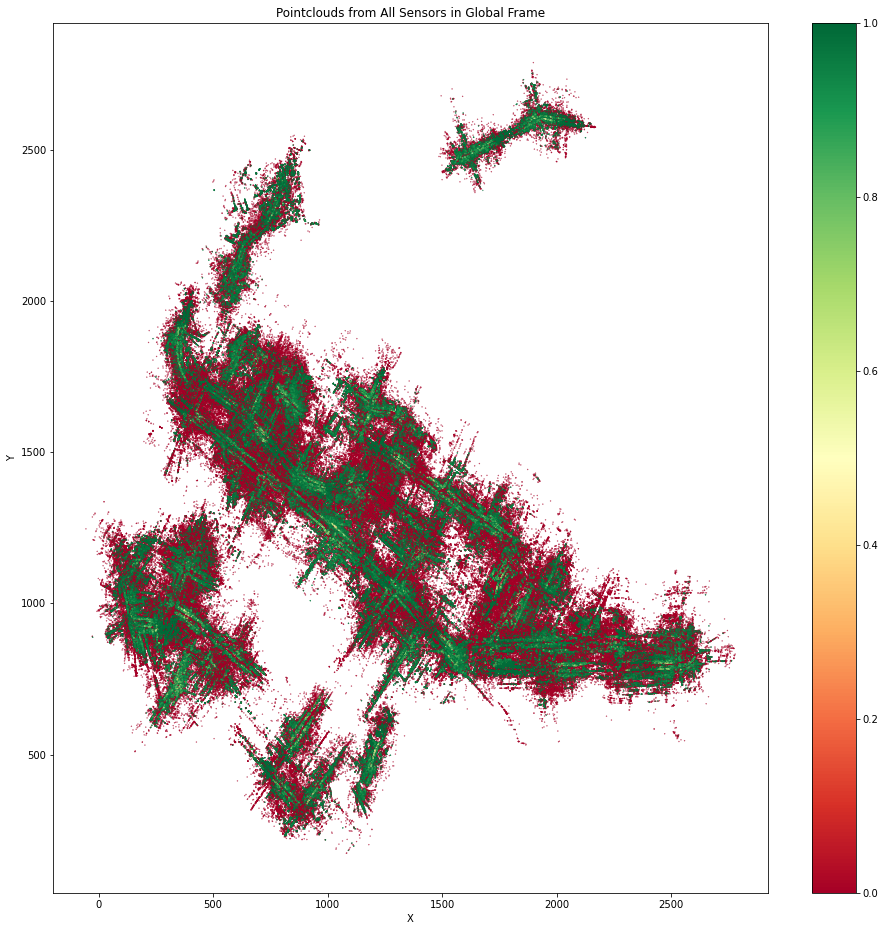

In [12]:
import matplotlib.pyplot as plt
# Create scatter plot
fig = plt.figure(figsize=(16, 16))
ax = fig.add_subplot(111)
sc = ax.scatter(full_map[:, 0], full_map[:, 1], c=full_map[:,-1], cmap='RdYlGn', s=0.1)

ax.set_xlabel('X')
ax.set_ylabel('Y')
plt.colorbar(sc)
plt.title('Pointclouds from All Sensors in Global Frame')
plt.show()